In [1]:
# https://plotly.com/python/v3/ipython-notebooks/markowitz-portfolio-optimization/

## An experiment using random generated data

In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd
from pandas_datareader import data

np.random.seed(123)

# Turn off progress printing 
solvers.options['show_progress'] = False

In [3]:
import plotly
import cufflinks
plotly.__version__

'4.6.0'

In [4]:
# (*) To communicate with Plotly's server, sign in with credentials file
import chart_studio.plotly as py  

# (*) Useful Python/Plotly tools
import plotly.tools as tls   

# (*) Graph objects to piece together plots
from plotly.graph_objs import *

In [5]:
## NUMBER OF ASSETS
n_assets = 4

## NUMBER OF OBSERVATIONS
n_obs = 1000

return_vec = np.random.randn(n_assets, n_obs)

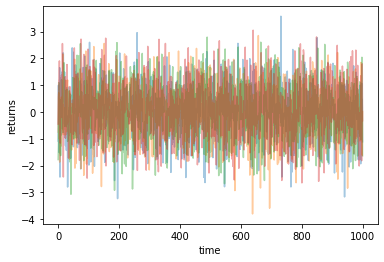

In [13]:
plt.plot(return_vec.T, alpha=.4);
plt.xlabel('time')
plt.ylabel('returns')
plt.show()

In [8]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

print(rand_weights(n_assets))
print(rand_weights(n_assets))

[0.54066805 0.2360283  0.11660484 0.1066988 ]
[0.27638339 0.03006307 0.47850085 0.21505269]


In [9]:
def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

In [11]:
n_portfolios = 500
means, stds = np.column_stack([
    random_portfolio(return_vec) 
    for _ in range(n_portfolios)
])

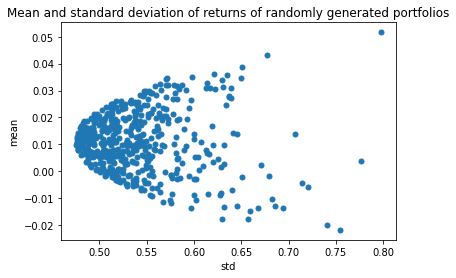

In [12]:
plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')
plt.show()

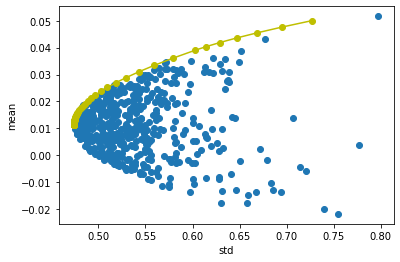

In [14]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

weights, returns, risks = optimal_portfolio(return_vec)

plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')
plt.show()

In [15]:
print(weights)

[[2.77880107e-09]
 [3.20322848e-06]
 [1.54301198e-06]
 [9.99995251e-01]]


## Using this now on real Data

In [25]:
end = pd.Timestamp.utcnow()
start = end - 2500 * pd.tseries.offsets.BDay()

# Define the instruments to download. We would like to see Apple, Microsoft and the S&P500 index.
tickers = ['IBM', 'GLD', 'XOM', 'AAPL', 'MSFT', 'TLT', 'SHY']

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
data = data.DataReader(tickers, 'yahoo', start, end)

In [26]:
data.head()

Attributes       High                                                \
Symbols          AAPL         GLD         IBM       MSFT        SHY   
Date                                                                  
2010-10-08  42.071430  131.880005  139.089996  24.650000  84.489998   
2010-10-11  42.462856  132.330002  139.940002  24.740000  84.500000   
2010-10-12  42.785713  132.210007  139.990005  24.930000  84.480003   
2010-10-13  43.137142  134.309998  141.479996  25.540001  84.440002   
2010-10-14  43.209999  134.850006  141.500000  25.340000  84.419998   

Attributes                               Low                          \
Symbols            TLT        XOM       AAPL         GLD         IBM   
Date                                                                   
2010-10-08  105.459999  64.529999  41.428570  130.470001  138.059998   
2010-10-11  104.430000  64.809998  42.085712  130.979996  138.639999   
2010-10-12  104.760002  64.889999  41.784286  131.360001  138.270004   
2010-10-13  103.120003  65.290001  42.828571  132.630005  139.779999   
2010-10-14  103.650002  65.449997  42.914288  133.899994  139.690002   

Attributes    ...         Volume                          Adj Close  \
Symbols       ...            SHY         TLT         XOM       AAPL   
Date          ...                                                     
2010-10-08    ...      1604700.0   6128700.0  22370500.0  36.466404   
2010-10-11    ...      1051900.0   1474200.0  13848900.0  36.626366   
2010-10-12    ...       950600.0   6122400.0  20732000.0  37.020699   
2010-10-13    ...       645700.0   8168400.0  22560500.0  37.219105   
2010-10-14    ...      1130100.0  10945000.0  17778100.0  37.488209   

Attributes                                                                      
Symbols            GLD         IBM       MSFT        SHY        TLT        XOM  
Date                                                                            
2010-10-08  131.660004  100.753845  19.567801  77.487831  80.105125  46.885700  
2010-10-11  132.289993  101.341621  19.583729  77.497009  80.120445  47.009518  
2010-10-12  131.960007  101.479500  19.774874  77.441902  79.328796  47.118752  
2010-10-13  134.070007  101.856827  20.181038  77.451096  79.205849  47.366360  
2010-10-14  134.750000  102.676788  20.093430  77.414375  78.022179  47.555725  

[5 rows x 42 columns]

In [39]:
print(data.columns)

MultiIndex(levels=[['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], ['AAPL', 'GLD', 'IBM', 'MSFT', 'SHY', 'TLT', 'XOM']],
           labels=[[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5], [0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6]],
           names=['Attributes', 'Symbols'])


In [47]:
data.iloc[['High'

ValueError: invalid literal for int() with base 10: 'High'